# Saisonnalités, changement de régime, COVID en France

On s'intéresse aux séries temporelles de l'épidémie du COVID en France récupérées depuis data.gouv.fr : [Chiffres-clés concernant l'épidémie de COVID19 en France](https://www.data.gouv.fr/en/datasets/chiffres-cles-concernant-lepidemie-de-covid19-en-france/).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Données

In [3]:
from pandas import DataFrame, read_csv, to_datetime
df = read_csv("https://www.data.gouv.fr/en/datasets/r/0b66ca39-1623-4d9c-83ad-5434b7f9e2a4")
df.tail()

c:\python387_x64\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,granularite,maille_code,maille_nom,cas_confirmes,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,deces,deces_ehpad,reanimation,hospitalises,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_url,source_archive,source_type
43080,2021-02-10,region,REG-75,Nouvelle-Aquitaine,NaN,NaN,NaN,NaN,2510.0,NaN,213.0,1524.0,78.0,20.0,10227.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43081,2021-02-10,region,REG-76,Occitanie,NaN,NaN,NaN,NaN,2882.0,NaN,276.0,1886.0,121.0,25.0,12801.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43082,2021-02-10,region,REG-84,Auvergne-Rhône-Alpes,NaN,NaN,NaN,NaN,8453.0,NaN,400.0,3699.0,213.0,42.0,34579.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43083,2021-02-10,region,REG-93,Provence-Alpes-Côte d'Azur,NaN,NaN,NaN,NaN,5010.0,NaN,438.0,3581.0,240.0,33.0,24080.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr
43084,2021-02-10,region,REG-94,Corse,NaN,NaN,NaN,NaN,133.0,NaN,7.0,58.0,4.0,3.0,587.0,NaN,OpenCOVID19-fr,NaN,NaN,opencovid19-fr


In [4]:
# Il y a une date 2020-11_11
df['date'] = to_datetime(df['date'].apply(lambda s: s.replace("_", "-")))

In [5]:
gr = df[["date", "cas_confirmes"]].groupby("date").sum().sort_index()
gr.tail()

,cas_confirmes
date,
2021-02-06,3317333.0
2021-02-07,3337048.0
2021-02-08,3341365.0
2021-02-09,3360235.0
2021-02-10,3385622.0


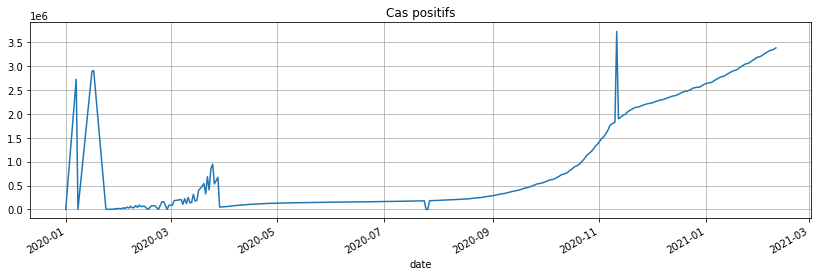

In [6]:
gr['cas_confirmes'].plot(figsize=(14, 4), grid=True, title="Cas positifs");

Il y a des petits problèmes de données... On corrige de façon automatique ou à la main... Etant donné que les données n'étaient pas fiables avant juin 2020 car pas assez de tests, on commence la série en septembre 2020. Il ne reste donc plus qu'une date un peu problématique, le 11 novembre.

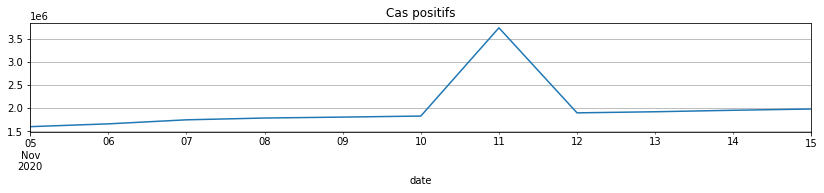

In [7]:
from datetime import datetime
gr.loc[(gr.index >= datetime(2020, 11, 5)) & (gr.index <= datetime(2020, 11, 15)), 'cas_confirmes'].plot(
    figsize=(14, 2), grid=True, title="Cas positifs");

In [8]:
gr.loc[datetime(2020, 11, 11), 'cas_confirmes'] = (
    gr.loc[datetime(2020, 11, 10), 'cas_confirmes'] + gr.loc[datetime(2020, 11, 12), 'cas_confirmes']) / 2

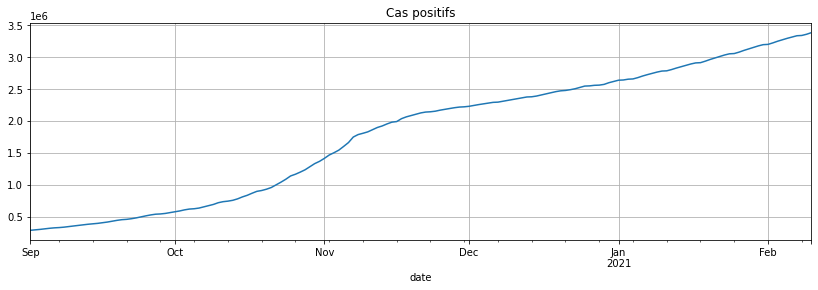

In [9]:
gr.loc[gr.index >= datetime(2020, 9, 1), 'cas_confirmes'].plot(figsize=(14, 4), grid=True, title="Cas positifs");

C'est mieux. On regarde la série différenciée :

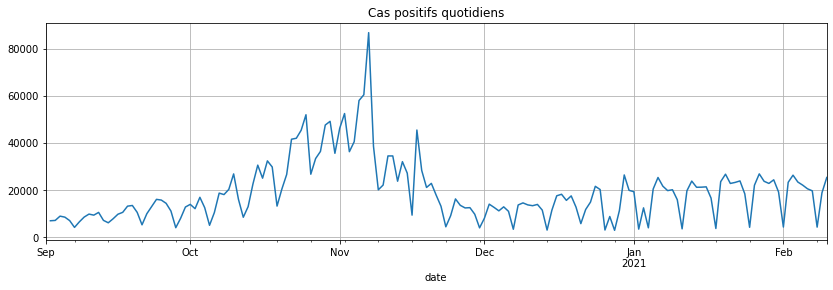

In [10]:
covsept = gr.loc[gr.index >= datetime(2020, 9, 1), 'cas_confirmes']
covsept.diff().plot(figsize=(14, 4), grid=True, title="Cas positifs quotidiens");

## Changements de régimes

### fbprophet quand ça marche

In [11]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
try:
    m = Prophet(changepoint_prior_scale=0.5)
    fig = m.plot(covsept)
    a = add_changepoints_to_plot(fig.gca(), m, covsept)
except AttributeError as e:
    print(e)
    # Sur Windows, fbprophet est compliqué à installer.
    # J'ai abandonné. C'est plus simple sous Linux.

Importing plotly failed. Interactive plots will not work.


'Prophet' object has no attribute 'stan_backend'


On passe à un autre module. Il compare localement la moyenne de la série à la série elle-même. Sur ce type de série avec une périodicité, ça ne marche pas très bien.

### Ecart à la moyenne

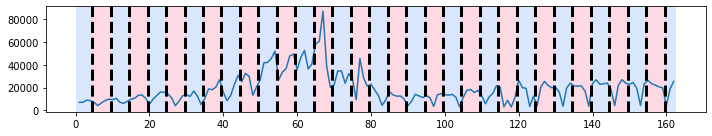

In [12]:
import ruptures

signal = covsept.diff().values

algo = ruptures.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

ruptures.display(signal, result, result);

In [13]:
import numpy
signal = covsept.diff().values
X = numpy.arange(signal.shape[0]).reshape(-1, 1).astype(signal.dtype)[1:]
y = signal[1:]
X.shape, y.shape

((162, 1), (162,))

### Cuisine maison

Donc je suis finalement passé à quelque chose que j'ai codé : un arbre de régression mais donc chaque feuille est une régression linéaire et non une constante. Ca manque un peu de théorie mais rien n'empêche d'être un peu inventif :[PiecewiseTreeRegressor](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mlmodel/piecewise_tree_regression.html).

In [14]:
from mlinsights.mlmodel import PiecewiseTreeRegressor
ptr = PiecewiseTreeRegressor(min_samples_leaf=14)
ptr.fit(X, y)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\tree\_classes.py:335: FutureWarning: The parameter 'X_idx_sorted' is deprecated and has no effect. It will be removed in 1.1 (renaming of 0.26). You can suppress this warning by not passing any value to the 'X_idx_sorted' parameter.
  warnings.warn(


PiecewiseTreeRegressor(min_samples_leaf=14)

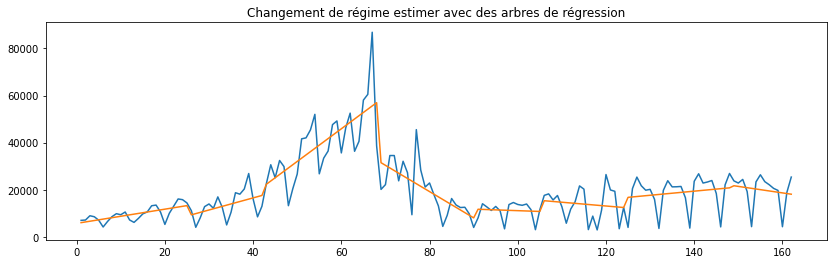

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(X, y)
ax.plot(X, ptr.predict(X))
ax.set_title("Changement de régime estimer avec des arbres de régression");

L'épidémie progresse de façon explonentielle. Il vaudrait sans doute mieux étudier le logarithme de la série différenciée.

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\tree\_classes.py:335: FutureWarning: The parameter 'X_idx_sorted' is deprecated and has no effect. It will be removed in 1.1 (renaming of 0.26). You can suppress this warning by not passing any value to the 'X_idx_sorted' parameter.
  warnings.warn(


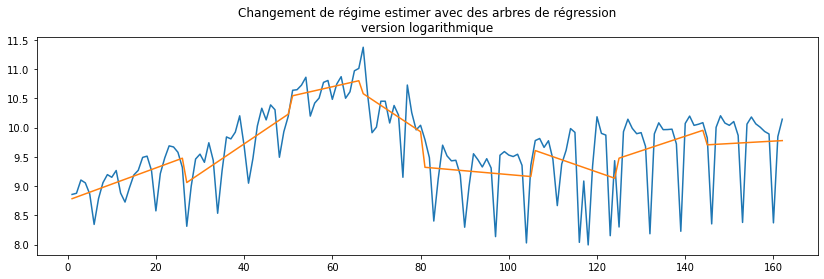

In [16]:
ptrl = PiecewiseTreeRegressor(min_samples_leaf=14)
ly = numpy.log(y)
ptrl.fit(X, ly)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(X, ly)
ax.plot(X, ptrl.predict(X))
ax.set_title("Changement de régime estimer avec des arbres de régression"
             "\nversion logarithmique");

C'est un petit peu mieux. Cette méthode s'applique surtout à la tendance des séries contrairement à la méthode suivante plus approprié pour segmenter les résidus.

### Gaussian Hidden Markov Model

Qu'est-ce ?

In [17]:
from hmmlearn.hmm import GaussianHMM
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
model.fit(ly.reshape(-1, 1))
model

GaussianHMM(n_components=3, n_iter=1000)

In [18]:
hidden_states = model.predict(X)
dates = covsept.index[1:]
set(hidden_states)

{1}

Le model n'arrive à rien sauf à prédire une valeur constante.

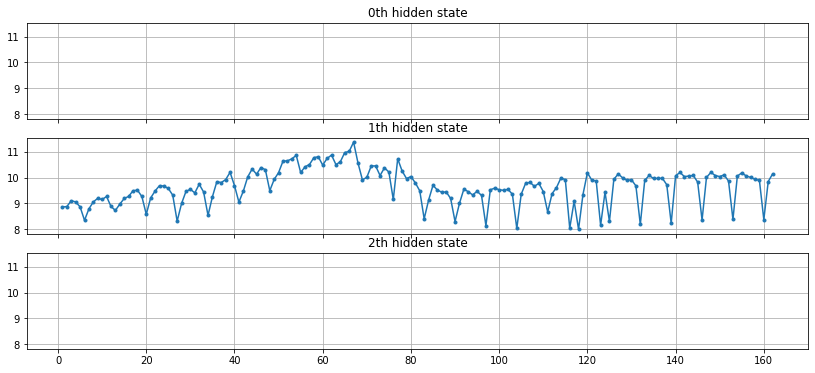

In [19]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(14, 6))
for i, ax in enumerate(axs):
    mask = hidden_states == i
    ax.plot(X[mask], ly[mask], ".-")
    ax.set_title("{0}th hidden state".format(i))
    ax.grid(True)

 Ca ne donne rien car la saisonnalité l'emporte sur le reste.

### Les modules classiques

* [seglearn](https://dmbee.github.io/seglearn/)
* [sktime](https://github.com/alan-turing-institute/sktime)
* [pyflux](https://pyflux.readthedocs.io/en/latest/dyn_lin.html)
* [hmmlearn](https://hmmlearn.readthedocs.io/en/stable/)
* [statsmodels](https://www.statsmodels.org/stable/index.html)

## Saisonnalité

### Saisonnalité et moyennes mobiles

<ipython-input-21-96d157ac9bae>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(ly, freq=7)


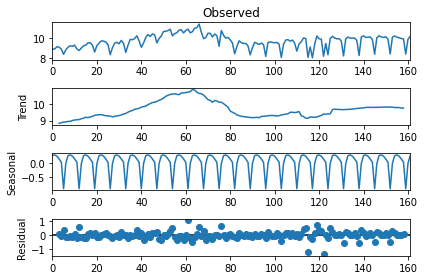

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(ly, freq=7)
res.plot();

In [21]:
res.resid[:10]

array([        nan,         nan,         nan,  0.07542526, -0.02752109,
        0.3475441 , -0.11152892, -0.15329366, -0.04130195, -0.09907971])

### Quelque chose qui n'a pas beaucoup de sens

In [22]:
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
ry = res.trend[3:-3]  # on enlève les nan
model.fit(ry.reshape(-1, 1))
hidden_states = model.predict(ry.reshape(-1, 1))
set(hidden_states)

{0, 1, 2}

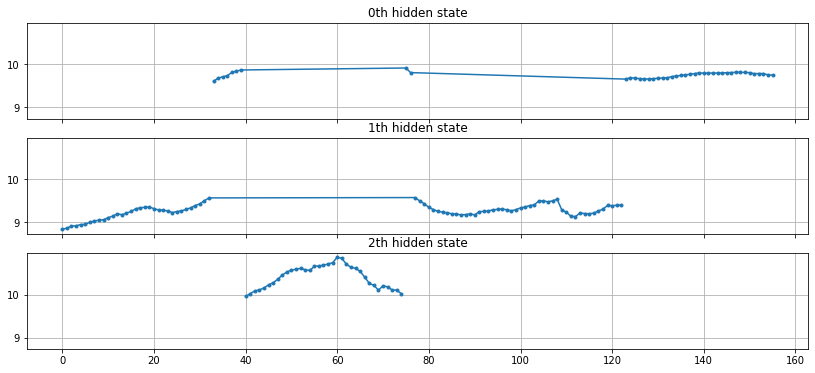

In [23]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(14, 6))
for i, ax in enumerate(axs):
    mask = hidden_states == i
    ax.plot(numpy.arange(0, ry.shape[0])[mask], ry[mask], ".-")
    ax.set_title("{0}th hidden state".format(i))
    ax.grid(True)

Si le modèle gaussien a l'air de fonctionner sur la série tendancielle (hors saisonnalité), il est plutôt utilisé pour segmenter selon la loi des résidus. Sur chaque segments, la série peut être approchée par une loi normale de moyenne et variance différentes.

In [24]:
model.means_, model.covars_

(array([[ 9.75077896],
        [ 9.26327355],
        [10.40300854]]),
 array([[[0.00506213]],
 
        [[0.02444731]],
 
        [[0.07163662]]]))

### ExponentialSmoothing

Le [lissage exponentiel](https://fr.wikipedia.org/wiki/Lissage_exponentiel) consite à modéliser la série comme suit :

$$
\begin{array}{rcl}
s_0 &=& y_0 \\
s_t &=& \alpha y_t + (1-\alpha) s_{t-1}  \text{ pour } t > 0
\end{array}
$$

Ou :

$$
\begin{array}{rcl}
s_1 &=& y_1 \\
\sigma_1 &=& y_1 - y_0 \\
s_t &=& \alpha y_t + (1-\alpha) (s_{t-1} + \sigma_{t-1})  \text{ pour } t > 1 \\
\sigma_t &=& \beta (s_t - s_{t-1}) + (1-\beta) \sigma_{t-1}  \text{ pour } t > 1
\end{array}
$$

Ou plus complexe avec [Holt Winters](https://en.wikipedia.org/wiki/Exponential_smoothing#Triple_exponential_smoothing_(Holt_Winters)):

$$
\begin{array}{rcl}
s_0 &=& y_0 \\
s_t &=& \alpha (y_t - c_{t - L}) + (1-\alpha) (s_{t-1} + b_{t-1}) \\
b_t &=& \beta(s_t - s_{t-1}) + (1-\beta)b_{t-1} \\
c_t &=& \gamma (y_t - s_{t-1} - b_{t-1}) + (1-\gamma)c_{t-L}
\end{array}
$$

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
fit1 = ExponentialSmoothing(y, seasonal_periods=7, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(y, seasonal_periods=7, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(y, seasonal_periods=7, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(y, seasonal_periods=7, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

c:\python387_x64\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\python387_x64\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
<ipython-input-26-0a978064fcad>:4: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit3 = ExponentialSmoothing(y, seasonal_periods=7, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
<ipython-input-26-0a978064fcad>:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit4 = ExponentialSmoothing(y, seasonal_periods=7, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)


In [26]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,162
Model:,ExponentialSmoothing,SSE,7985315446.470
Optimized:,True,AIC,2891.550
Trend:,Additive,BIC,2925.514
Seasonal:,Additive,AICC,2894.010
Seasonal Periods:,7,Date:,"Wed, 10 Feb 2021"
Box-Cox:,True,Time:,23:00:39
Box-Cox Coeff.:,0.19415,,
,coeff,code,optimized
smoothing_level,0.2185487,alpha,True
smoothing_trend,0.1681336,beta,True


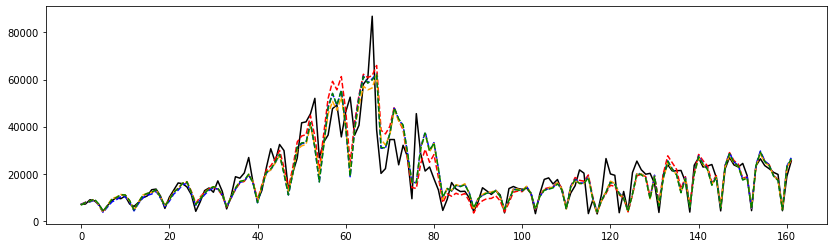

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(y, 'b', color='black', label="Cas positifs")
ax.plot(fit1.fittedvalues, '--', color='red')
ax.plot(fit2.fittedvalues, '--', color='blue')
ax.plot(fit3.fittedvalues, '--', color='orange')
ax.plot(fit4.fittedvalues, '--', color='green');

### Single Spectrum Analysis (SSA)

Le module [pyts]() ne fonctionnait pas pour moi. Je suis alors le notebook [Single Spectrum Analysis (SSA)](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/timeseries_ssa.html).

In [28]:
def lagged_ts(serie, lag):
    dim = serie.shape[0]
    res = numpy.zeros((dim - lag + 1, lag))
    for i in range(lag):
        res[:, i] = serie[i:dim-lag+i+1]
    return res

lagged_ts(y, 3)[:5]

array([[7017., 7157., 8975.],
       [7157., 8975., 8550.],
       [8975., 8550., 7071.],
       [8550., 7071., 4203.],
       [7071., 4203., 6544.]])

In [29]:
n_lag = 7
lag = lagged_ts(y, n_lag)
u, s, vh = svd(lag)
u.shape

(156, 156)

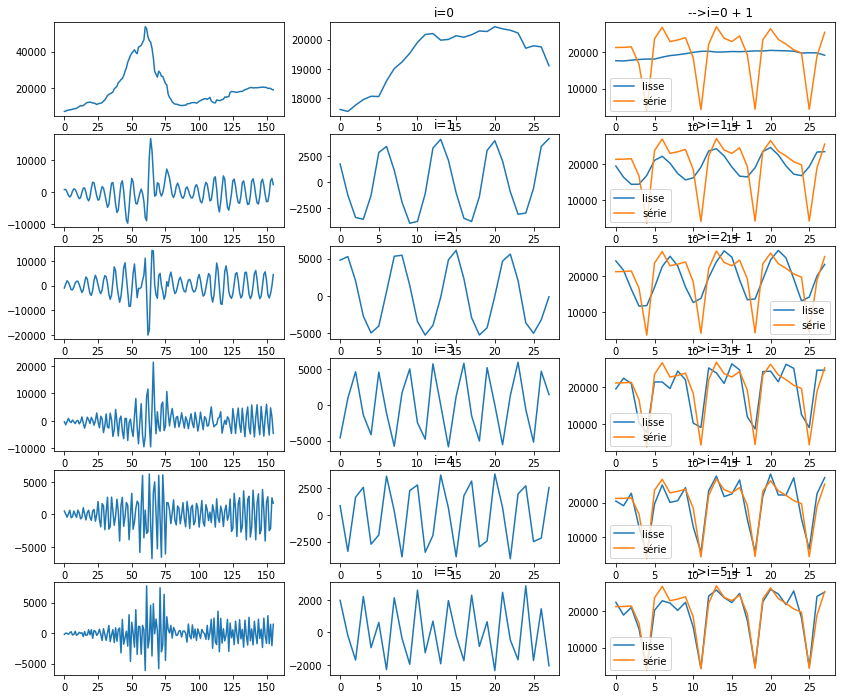

In [30]:
from numpy.linalg import svd
np = 6
fig, ax = plt.subplots(np, 3, figsize=(14, np*2))
for n in range(np):
    i = n
    d = numpy.zeros((u.shape[0], n_lag))
    d[i, i] = s[i]
    X2 = u @ d @ vh
    pos = 0 #X2.shape[1] - 1

    # série reconstruites avec un axe
    ax[n, 0].plot(X2[:,pos])
    ax[n, 1].set_title("i=%d" % i)
    ax[n, 1].plot(X2[-29:-1:,pos])

    d = numpy.zeros((u.shape[0], n_lag))
    d[:i+1, :i+1] = numpy.diag(s[:i+1])
    X2 = u @ d @ vh
    ax[n, 2].plot(X2[-29:-1,pos], label="lisse")
    ax[n, 2].plot(y[-28:], label="série")
    ax[n, 2].set_title("-->i=%d + 1" % i)
    ax[n, 2].legend()

### Points aberrants

In [31]:
d = numpy.zeros((u.shape[0], n_lag))
for i in range(0, d.shape[1]):
    d[i, i] = s[i]
X2 = u @ d @ vh

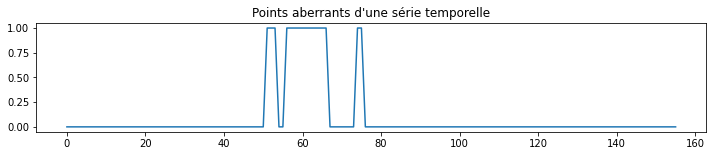

In [32]:
from sklearn.covariance import EllipticEnvelope
env = EllipticEnvelope(support_fraction=0.9)
env.fit(X2[:,:n_lag // 2])
out = env.predict(X2[:,:n_lag // 2])

fig, ax = plt.subplots(1, 1, figsize=(12,2))
ax.plot((1 - out)/2, "-")
ax.set_title("Points aberrants d'une série temporelle");

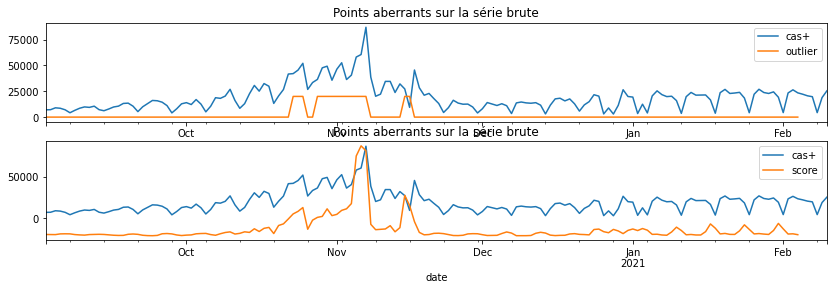

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(14,4))
outp = env.decision_function(X2[:,:n_lag // 2])
dfy = DataFrame(data=y, index=dates, columns=["cas+"])
dfy['outlier'] = dfy['score'] = numpy.nan
dfy.iloc[:-n_lag+1, 1] = (1 - out)*1e4
dfy.iloc[:-n_lag+1, 2] = -outp*1e3
dfy[['cas+', 'outlier']].plot(ax=ax[0])
ax[0].set_title("Points aberrants sur la série brute");
dfy[['cas+', 'score']].plot(ax=ax[1])
ax[1].set_title("Points aberrants sur la série brute");